## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>
    
### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>
**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Импорт необходимых бибилиотек**

In [1]:
import pandas as pd
import numpy as np
import pickle
import random
from pathlib import Path
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
# !pip install catboost
# !pip install xgboost
# !pip install lightgbm
# !pip install -U imbalanced-learn

In [4]:
# conda install -c conda-forge imbalanced-learn

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [7]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [8]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [9]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [10]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

**Пути к директориям и файлам**

In [11]:
DATA_ROOT = Path('C:/Users/druzh/Desktop/data scientist/lib_Python_for_DS_continue/course_project/' )
MODELS_PATH = Path('C:/Users/druzh/Desktop/data scientist/lib_Python_for_DS_continue/course_project/models/')

# input
DATASET_PATH = DATA_ROOT / 'course_project_train.csv'
TEST_PATH = DATA_ROOT / 'course_project_test.csv'
PREP_DATASET_PATH = DATA_ROOT / 'course_project_train_prep.csv'
PREP_TEST_PATH = DATA_ROOT / 'course_project_test_prep.csv'

# output
TRAIN_FULL_PATH = DATA_ROOT / 'course_project_train_full.csv'
TRAIN_PART_PATH = DATA_ROOT / 'course_project_train_part_b.csv'
TEST_PART_PATH = DATA_ROOT / 'course_project_test_part.csv'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

SUBMIT_PATH = DATA_ROOT / 'credit_submition.csv'

# # input
# DATASET_PATH = r'C:\Users\druzh\Desktop\data scientist\lib_Python_for_DS_continue\course_project\course_project_train.csv'
# TEST_PATH = r'C:\Users\druzh\Desktop\data scientist\lib_Python_for_DS_continue\course_project\course_project_test.csv'
# # output
# PREP_DATASET_PATH = r'C:\Users\druzh\Desktop\data scientist\lib_Python_for_DS_continue\course_project\course_project_train_prep.csv'
# PREP_TEST_PATH = r'C:\Users\druzh\Desktop\data scientist\lib_Python_for_DS_continue\course_project\course_project_test_prep.csv'
# SUBMIT_PATH = r'C:\Users\druzh\Desktop\data scientist\lib_Python_for_DS_continue\course_project\credit_submition.csv'

### Загрузка данных<a class="anchor" id="load_data"></a>

In [12]:
df_train = pd.read_csv(DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [13]:
df_train.shape

(7500, 17)

In [14]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [16]:
df_test = pd.read_csv(TEST_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [17]:
df_test.shape

(2500, 16)

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

### Приведение типов<a class="anchor" id="cast"></a>

In [19]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

### Обзор данных<a class="anchor" id="review"></a>

**Обзор целевой переменной**

In [20]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Обзор количественных признаков**

In [21]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [22]:
df_train['Current Loan Amount'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

**Обзор номинативных признаков**

In [23]:
def df_info(df):
    for cat_colname in df.select_dtypes(include='object').columns:
        print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

In [24]:
df_info(df_train)

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [25]:
df_info(df_test)

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving               

### Обзор данных с пропусками

In [26]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [27]:
df_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [28]:
print(df_train['Months since last delinquent'].mode())
df_train.groupby(['Tax Liens'])['Months since last delinquent'].median()

0    14.0
dtype: float64


Tax Liens
0.0    32.0
1.0    33.0
2.0    37.5
3.0    36.5
4.0    43.0
5.0    63.5
6.0    46.5
7.0    54.0
Name: Months since last delinquent, dtype: float64

### Посмотрим на коррляцию признаков

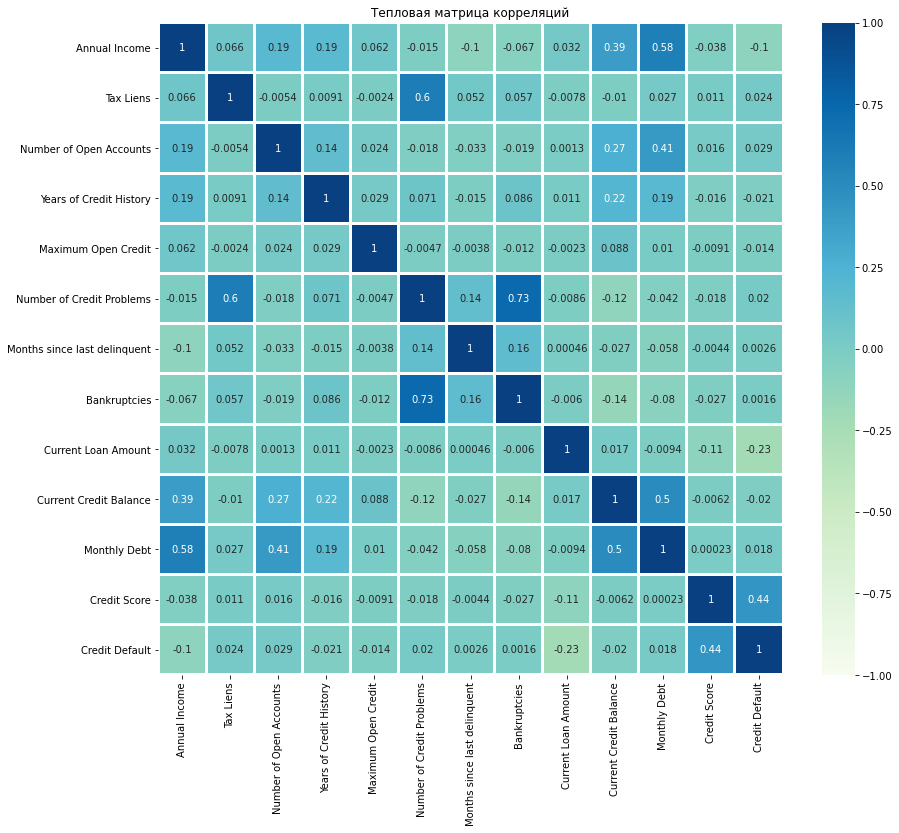

In [29]:
plt.rcParams['figure.figsize'] = (14.0, 12.0)
sns.heatmap(df_train.corr(), annot = True,fmt='.2g', vmin=-1, vmax=1, center= 0, linewidths = 2, cmap = 'GnBu')
plt.title('Тепловая матрица корреляций')
plt.show()

### Обработка пропусков<a class="anchor" id="gaps"></a>

- Все категориальные фичи, кроме Years in current job (количество лет на текущем месте работы), в обоих датасетах не имеют       пустых значений.

- Пустые значения в Years in current job заменим модой.

- Annual Income - пропуски в годовом доходе заменим медианой.

- Months since last delinquent - слишком много пропусков, более половины (4081 из 7500), заполним нулями, будем считать что просрочки нет.

- Bankruptcies - банкротства: пропусков очень мало, заменим нулями.

- Credit Score - кредитный рейтинг, пропуски заменим медианой.

In [30]:
# train_df.loc[:, ['Months since last delinquent', 'Bankruptcies', 'Credit Score']] = train_df.loc[:, ['Months since last delinquent','Bankruptcies', 'Credit Score']].fillna(value=0)
# train_df['Annual Income'].fillna(value=train_df['Annual Income'].mean(), inplace=True)
# train_df.info()

**Bankruptcies**

In [31]:
df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies'] = 0
df_test.loc[df_test['Bankruptcies'].isna(), 'Bankruptcies'] = 0

In [32]:
# df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = df_train.loc[df_train['Tax Liens'], 'Bankruptcies'].mode()[0]

**Months since last delingment**

In [33]:
df_train.loc[(df_train['Months since last delinquent'].isna()), 'Months since last delinquent'] = 0
df_test.loc[(df_test['Months since last delinquent'].isna()), 'Months since last delinquent'] = 0

In [34]:
# df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df_train.loc[df_train['Tax Liens'], 'Months since last delinquent'].mode()[0]

**Years in current job**


In [35]:
print(df_train['Years in current job'].mode()[0])

10+ years


In [36]:
def Years_in_current_job(df):
    df.loc[df['Years in current job'].isnull(), 'Years in current job'] = df['Years in current job'].mode()[0]
    years_dict = {'10+ years':10,
                '2 years':2,
                '3 years':3,
                '< 1 year':0,
                '5 years':5,
                '1 year':1,
                '4 years':4,
                '6 years': 6,
                '7 years':7,
                '8 years':8,
                '9 years':9 
                 }

    df['Years_in_current_job'] = df['Years in current job'].map(years_dict).astype(int)
#     df.drop('Years in current job', axis=1, inplace=True)
    return df
Years_in_current_job(df_test)
Years_in_current_job(df_train)



,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Years_in_current_job
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,10
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,10
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,8
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,6
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,0.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,0.0,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0,6
7498,Home Mortgage,NaN,10+ years,0.0,21.0,26.5,1141250.0,0.0,0.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0,10


In [37]:
df_train['Monthly Debt'].median()

16076.5

In [38]:
df_train.loc[df_train['Monthly Debt'] == 0.0, 'Monthly Debt']

780     0.0
1643    0.0
3219    0.0
3496    0.0
4165    0.0
7124    0.0
Name: Monthly Debt, dtype: float64

**Annual Income**

In [39]:
df_train.loc[df_train['Annual Income'].isna(), 'Monthly Debt'].describe()


count     1557.000000
mean     18451.107900
std      12084.036473
min          0.000000
25%      10071.000000
50%      16048.000000
75%      23883.000000
max      96177.000000
Name: Monthly Debt, dtype: float64

In [40]:
def Annual_Income(df):
    df.loc[df['Annual Income'].isna(), 'Annual Income'] = df['Annual Income'].median()
    return df

Annual_Income(df_test)
Annual_Income(df_train)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Years_in_current_job
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,10
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,10
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,8
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,6
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,0.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,0.0,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0,6
7498,Home Mortgage,1168386.0,10+ years,0.0,21.0,26.5,1141250.0,0.0,0.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0,10


**Credit score**

In [41]:
df_train['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

In [42]:
def Credit_score(df):
    df.loc[(df['Credit Score'].isna()), 'Credit Score'] = df['Credit Score'].median()
    return df
Credit_score(df_train)
Credit_score(df_test)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Years_in_current_job
0,Rent,1178475.0,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0,4
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,1
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0,3
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,10
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0,10
2496,Home Mortgage,1178475.0,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,731.0,2
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,0.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0,2
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,0.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0,10


In [43]:
len(df_train) - df_train.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
Years_in_current_job            0
dtype: int64

In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [45]:
#Credit Score  
# df_train.loc[((df_train['Credit Score']>df_train['Credit Score'].quantile(.995))|(df_train['Credit Score']<df_train['Credit Score'].quantile(.005)))]

### Сохранение обучающего датасета<a class="anchor" id="saving"></a>

In [46]:
df_train.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')
df_test.to_csv(PREP_TEST_PATH , index=False, encoding='utf-8')

**Пути к директориям и файлам**

In [47]:
# # input
# DATASET_PATH = r'C:\Users\druzh\Desktop\data scientist\lib_Python_for_DS_continue\course_project\course_project_train.csv'
# TEST_PATH = r'C:\Users\druzh\Desktop\data scientist\lib_Python_for_DS_continue\course_project\course_project_test.csv'
# # output
# PREP_DATASET_PATH = r'C:\Users\druzh\Desktop\data scientist\lib_Python_for_DS_continue\course_project\course_project_train_prep.csv'
# PREP_TEST_PATH = r'C:\Users\druzh\Desktop\data scientist\lib_Python_for_DS_continue\course_project\course_project_test_prep.csv'

### Загрузка данных

In [48]:
df_base = pd.read_csv(DATASET_PATH)
df_train = pd.read_csv(PREP_DATASET_PATH)

df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Years_in_current_job
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,10
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,10
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,8
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,6
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,8


### Выделение целевой переменной и групп признаков

In [49]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
ALL_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                     'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 
                     'Current Credit Balance', 'Monthly Debt',  'Credit Score', 'Years_in_current_job']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term'] 

**Корреляция с базовыми признаками**

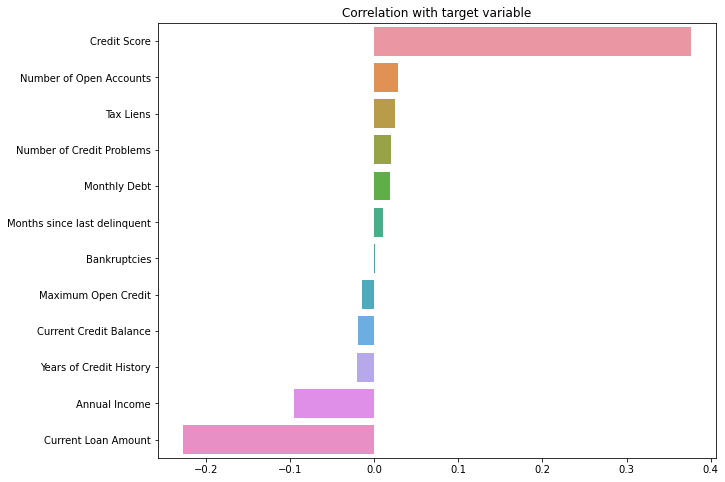

In [50]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()



Признаки 'Bankruptcies' и 'Months since last delinquent' имеют очень низкую корреляцию с целевой переменной, возможно их не нужно включать для обучения модели

In [51]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Проверим распределения вещественных признаков на трейне и тесте**

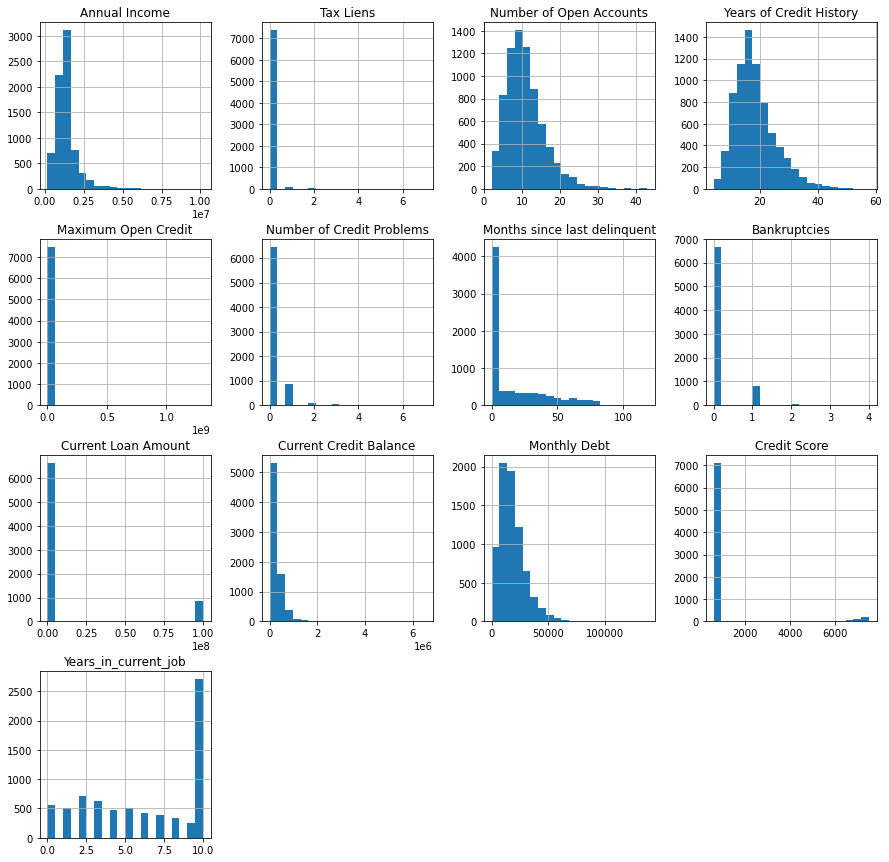

In [52]:
df_train[NUM_FEATURE_NAMES].hist(figsize=(15, 15), bins=20);

##### **Исследование вещественных признаков**

Annual Income
MannwhitneyuResult(statistic=8948146.5, pvalue=0.0003115420629796576)


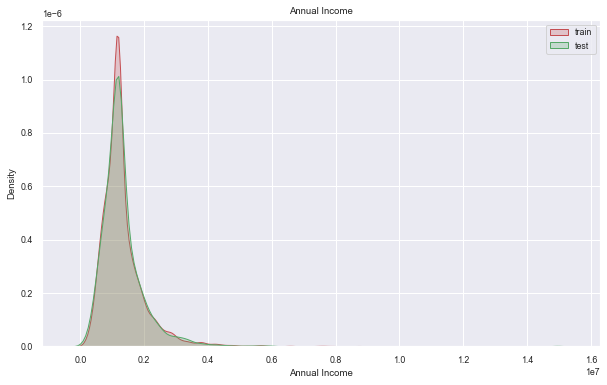

Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


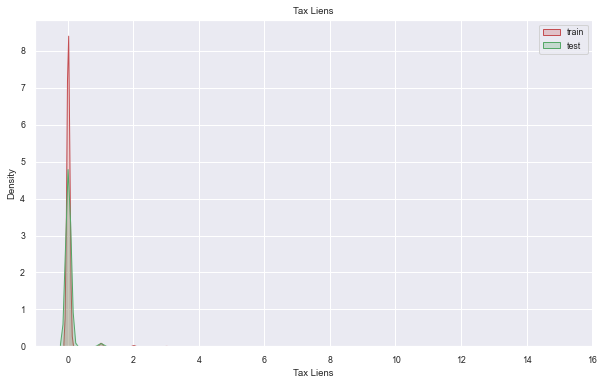

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


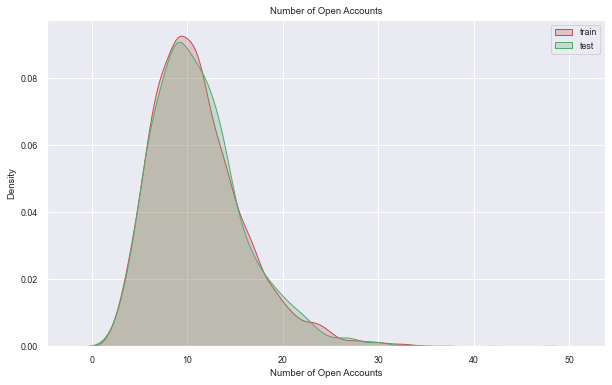

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


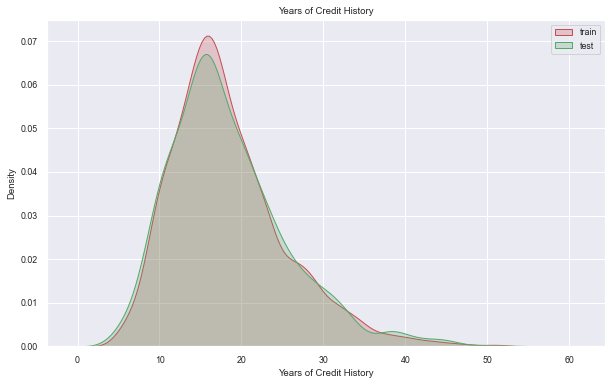

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


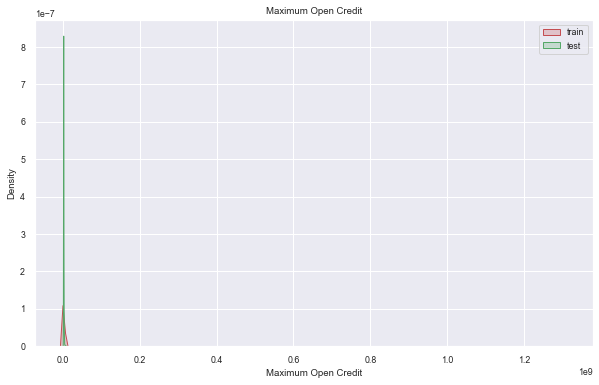

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


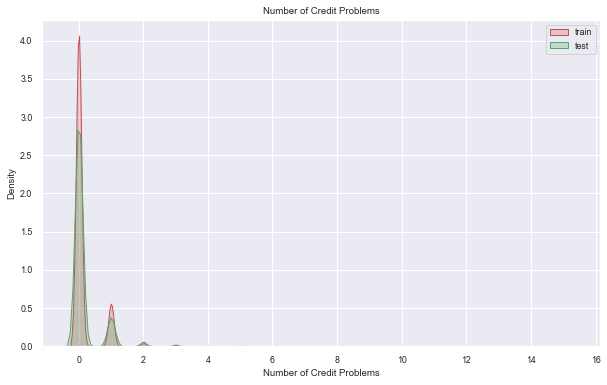

Months since last delinquent
MannwhitneyuResult(statistic=9346198.5, pvalue=0.40057108736095315)


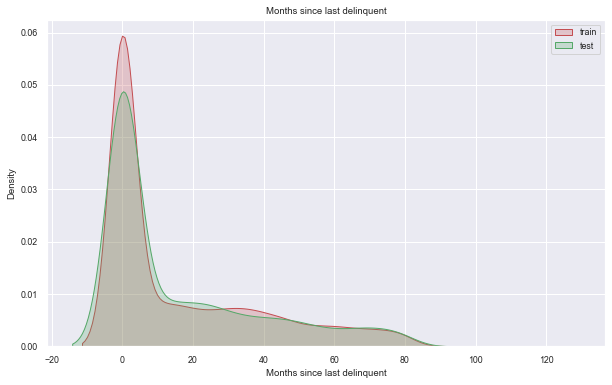

Bankruptcies
MannwhitneyuResult(statistic=9260973.0, pvalue=0.04432950519761078)


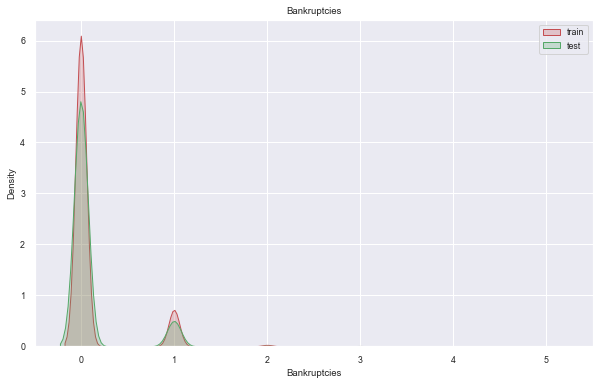

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


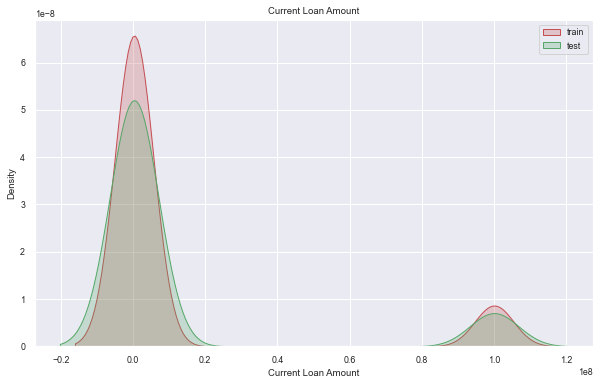

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


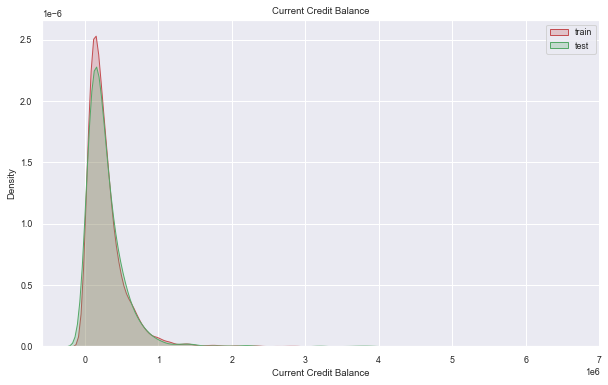

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


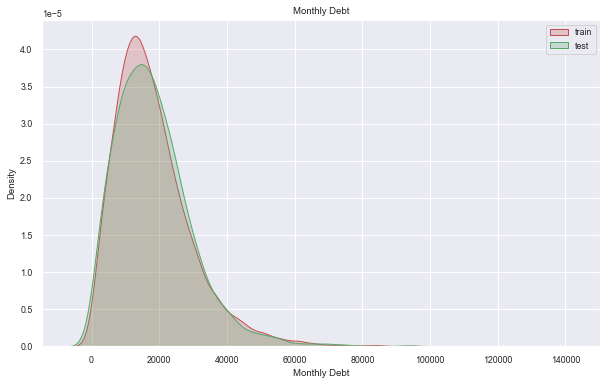

Credit Score
MannwhitneyuResult(statistic=9355026.0, pvalue=0.4361860976739489)


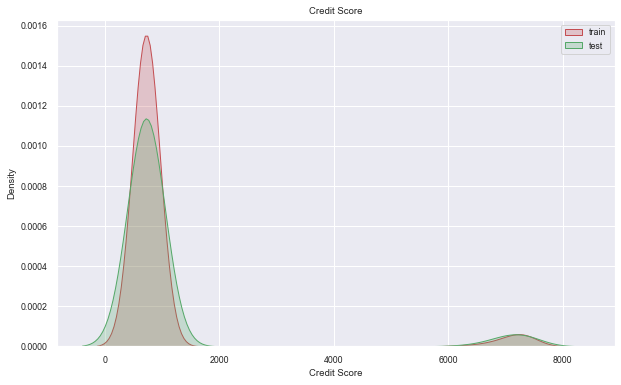

Years_in_current_job
MannwhitneyuResult(statistic=9374527.5, pvalue=0.4984547313663223)


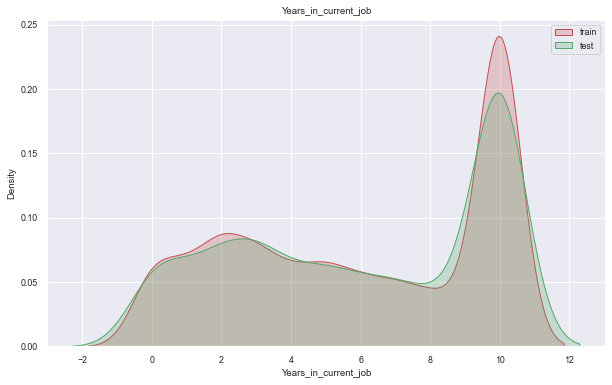

In [53]:
figsize = (10, 6)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df_train[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df_train[col], df_test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

**Проверим распределения категориальных признаков на трейне и тесте**

In [54]:
# # num_feature = 'Current Loan Amount'
# CAT_FEATURE = df_train.select_dtypes(include='object').columns.tolist()[:-1]
# figsize = (15, 3)
# for num_el in NUM_FEATURE_NAMES:
#     for col in CAT_FEATURE:
#         # for col in CAT_FEATURE_NAMES:
#         plt.figure(figsize=figsize)
#         sns.pointplot(x=col, y=num_el, data=df_train, capsize=.1, label='train', color='r')
#         sns.pointplot(x=col, y=num_el, data=df_test, capsize=.1, label='test', color='g')
#         plt.title(col) 
#         plt.show()

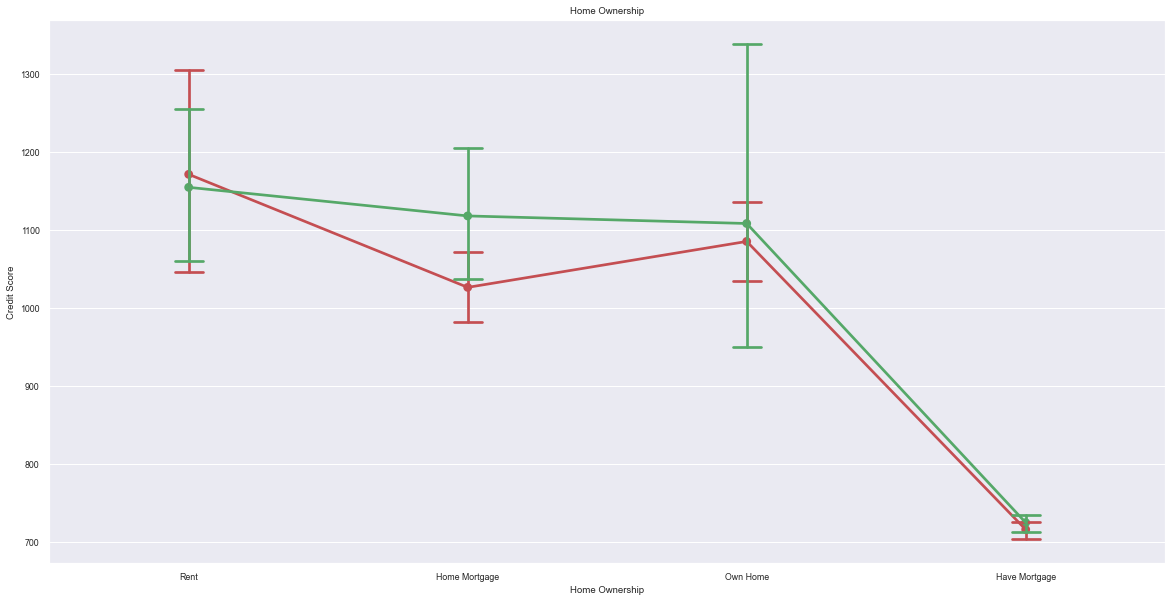

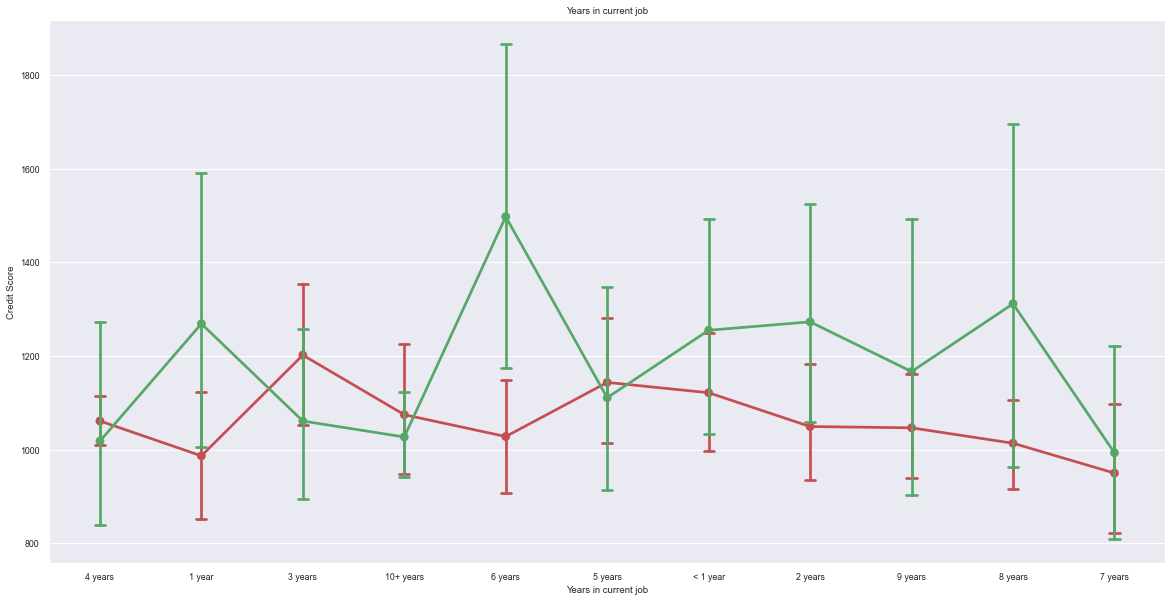

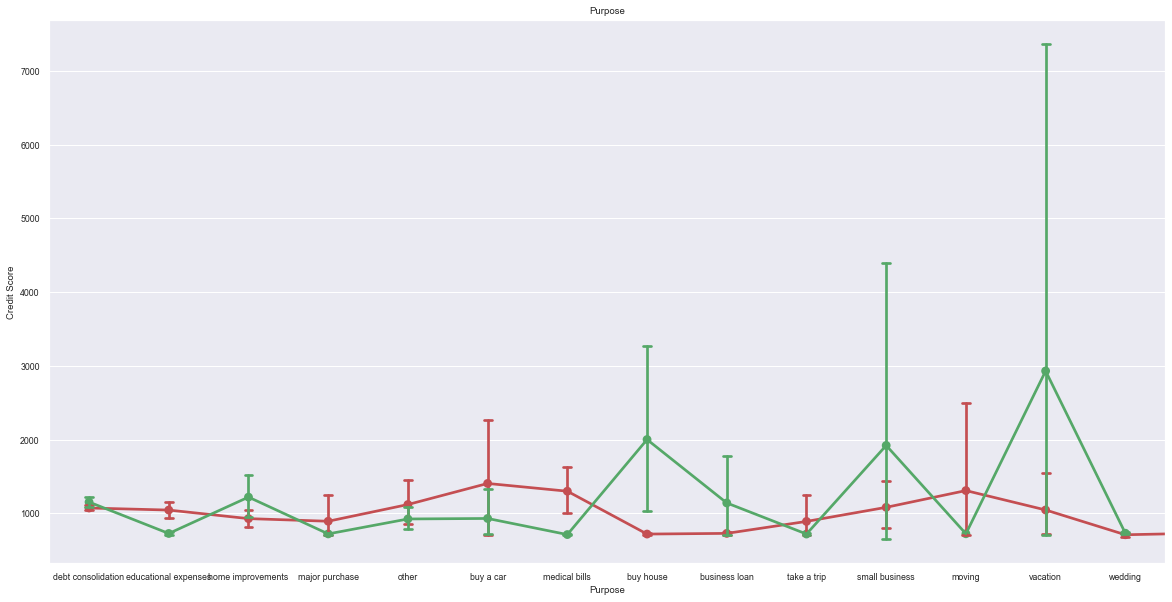

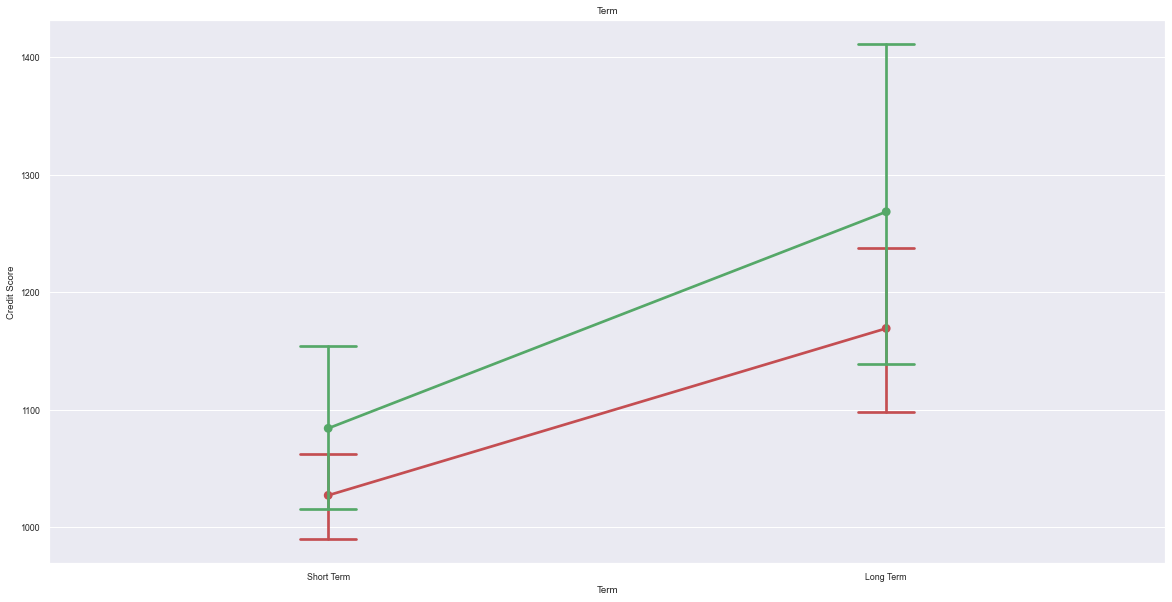

In [55]:
num_feature = 'Credit Score'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize= (20, 10))
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

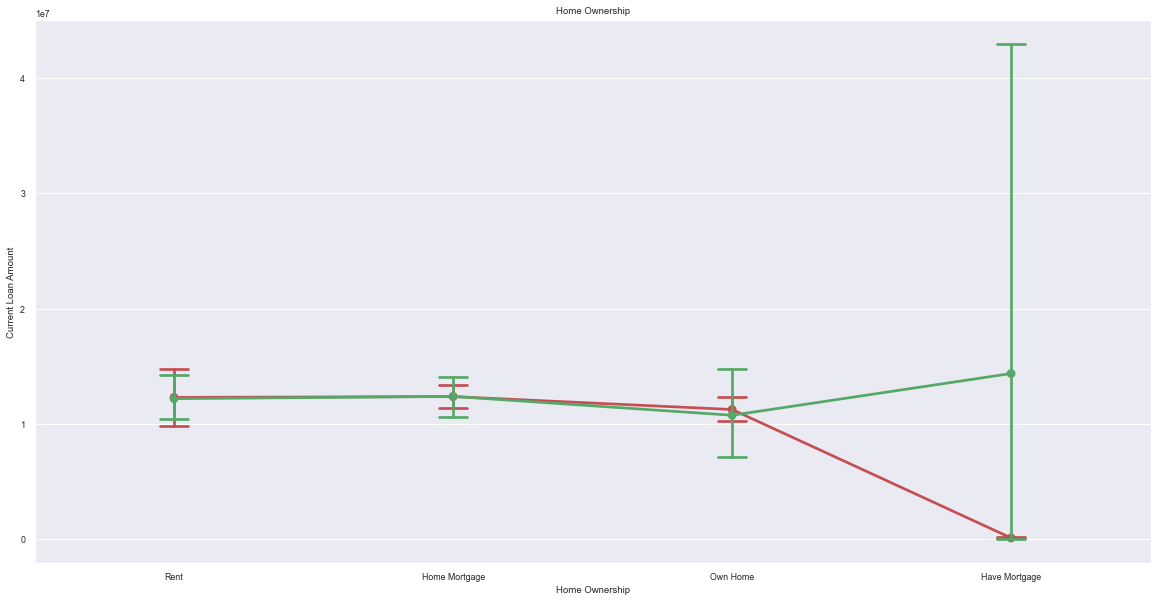

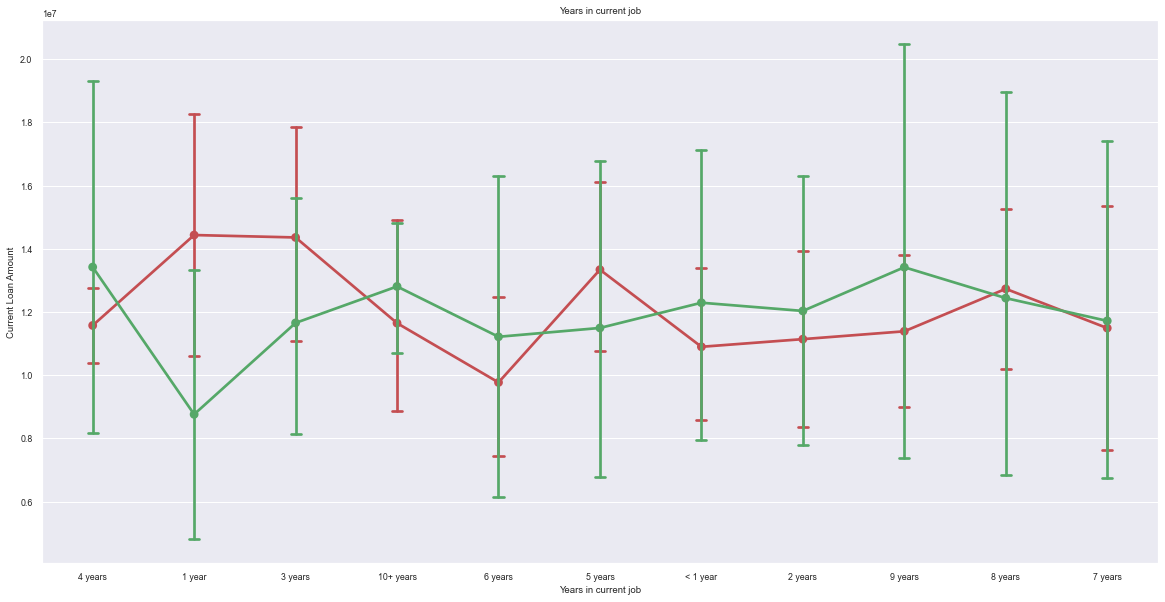

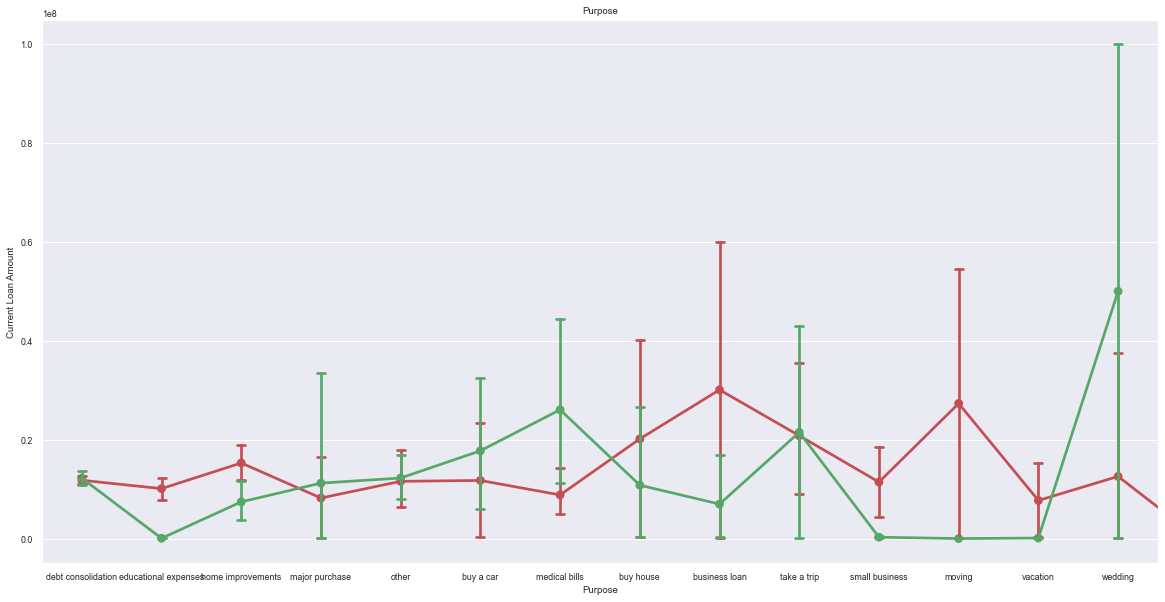

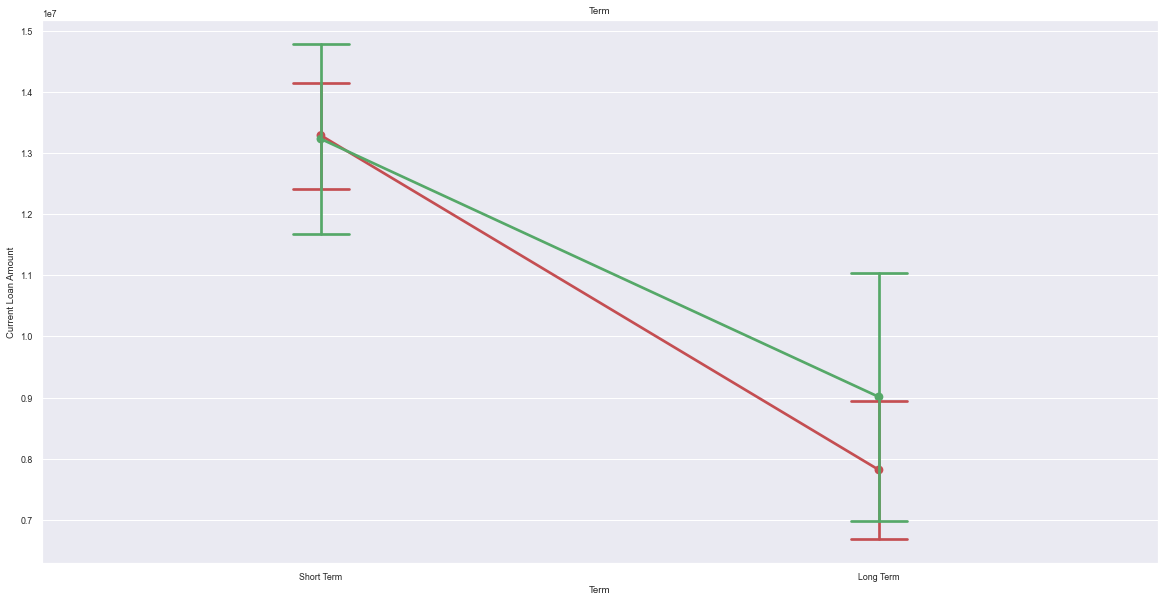

In [56]:

num_feature = 'Current Loan Amount'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize= (20, 10))
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

In [57]:
# def change_purpose(df):
#     df.loc[df['PAY_1'].isin([-1, 0]),'PAY_1'] = 0
# #     df.loc[df['PAY_1'].isin([2, 3]), 'PAY_1'] = 2
#     return df


# test = change_purpose(df_test)
# train = change_purpose(df_train)

In [58]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [59]:
df_test['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

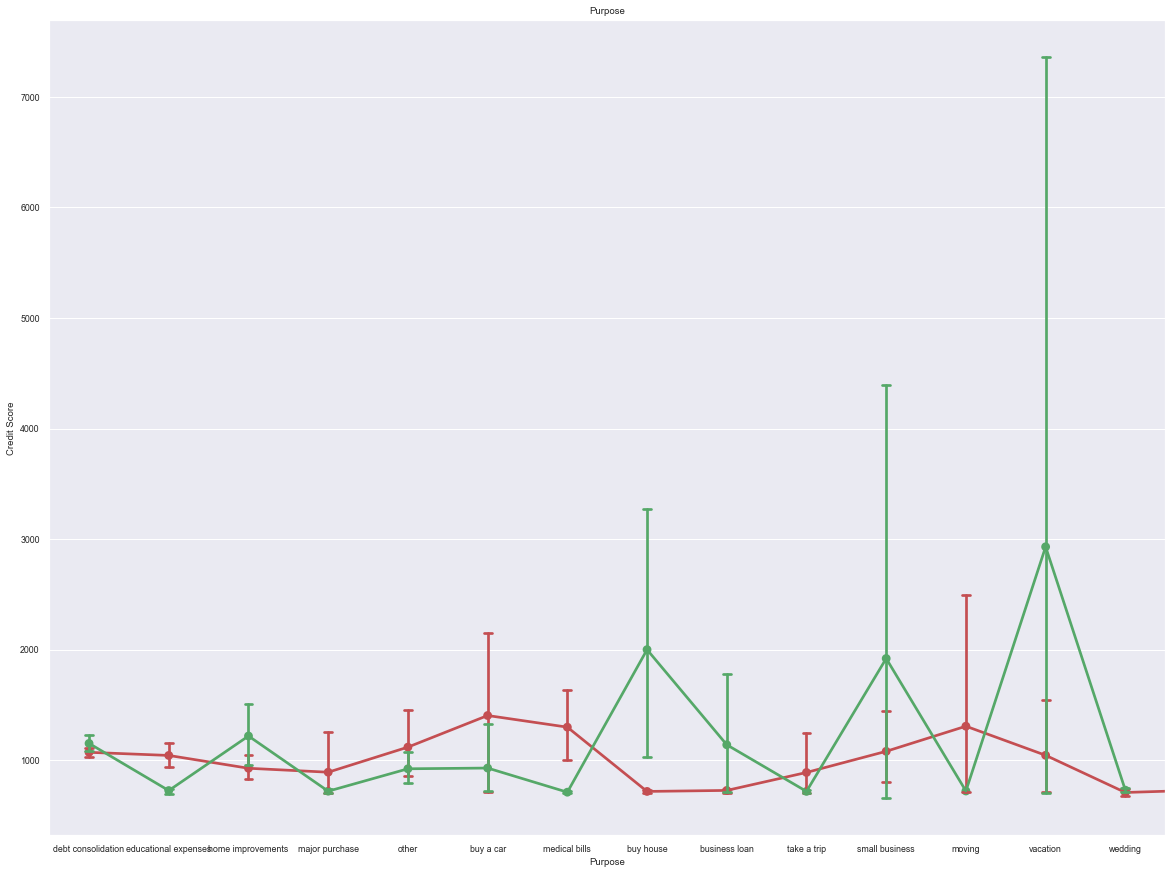

In [60]:
num_feature = 'Credit Score'
col = 'Purpose'
plt.figure(figsize=(20, 15))
sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
plt.title(col)
plt.show()

In [61]:
# del_cols = ['Bankruptcies', 'Months since last delinquent']

# df_train.drop(columns=del_cols, inplace=True)
# df_test.drop(columns=del_cols, inplace=True)

### Обработка выбросов<a class="anchor" id="outliers"></a>

#### Пропустим этот шаг

In [62]:

def preprocess_outlier(df, colum, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[colum] > threshold, colum] = np.nan
    return df

q995 = df_train.quantile(0.995)
feature_name = 'Annual Income'

# threshold=q995[feature_name]
df_copy = preprocess_outlier(df_train, feature_name, q995[feature_name])

df_copy[feature_name].isna().sum()

38

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler


def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]
    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)

    model = RandomForestRegressor(n_estimators=70,
                                  max_depth=10,
                                  random_state=42)
#                                   verbose=1)
    print(y_train)
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [64]:
# %%time
# annual_inome_predictor, df_copy = imputer_rfr(df_copy, feature_name)

In [65]:
# df_copy[feature_name].isna().sum()

In [66]:
# df_copy[feature_name].hist();

In [67]:
def data_prep(df):

    q995 = df.quantile(0.995)
    medians = df.median()      
    
    # Обработаем Annual Income
    ''' 
    Обработаем хвост справа при помощи квантиля 0.995. Все что выходит за рамки сделаем 
    пропусками и заполним медианами
    '''

    df.loc[df['Annual Income'] > q995['Annual Income'], 'Annual Income'] = np.NaN
    df.loc[(df['Annual Income'].isna()), 'Annual Income'] = medians['Annual Income']
    
    #Home Ownership

    df.loc[(df['Home Ownership'] == 'Have Mortgage'), 'Home Ownership'] = 'Home Mortgage'
    
    # Обработаем Number of Open Accounts
    '''
        Аналогично предыдущему обработаем хвост справа при помощи квантиля 0.995
        Все что выходит за рамки сделаем пропусками и заполним медианами
        
    '''
    df.loc[df['Number of Open Accounts'] > q995['Number of Open Accounts'], 'Number of Open Accounts'] = np.NaN
    df.loc[(df['Number of Open Accounts'].isna()), 'Number of Open Accounts'] = medians['Number of Open Accounts']
        
        # Обработаем Maximum Open Credit
    '''
        Аналогично квантиль 0.995
        Все что выходит за рамки сделаем пропусками и заполним медианами
    
    '''
    df.loc[df['Maximum Open Credit'] > q995['Maximum Open Credit'], 'Maximum Open Credit'] = np.NaN
    df.loc[(df['Maximum Open Credit'].isna()), 'Maximum Open Credit'] = medians['Maximum Open Credit']
        
          # Обработаем Current Loan Amount
    '''
        В данном примере квантиль не сильно исправлет от выбросов, поэтому возьмем примерную величину, основываясь на графике.
        Все что выходит за рамки сделаем пропусками
        
    '''
        # X.loc[X['Current Loan Amount'] > self.q995['Current Loan Amount'], 'Current Loan Amount'] = np.NaN
    df.loc[(df['Current Loan Amount'].isna()), 'Current Loan Amount'] = medians['Current Loan Amount']
    df.loc[(df['Current Loan Amount'] > 4500000), 'Current Loan Amount'] = medians['Current Loan Amount']
        
        # Обработаем Current Credit Balance
    '''
        Аналогично квантиль 0.995
        Все что выходит за рамки сделаем пропусками и заполним медианами
        
    '''
    df.loc[df['Current Credit Balance'] > q995['Current Credit Balance'], 'Current Credit Balance'] = np.NaN
    df.loc[(df['Current Credit Balance'].isna()), 'Current Credit Balance'] = medians['Current Credit Balance']
        
        # Обработаем Monthly Debt
    '''
        Аналогично квантиль 0.995
        Все что выходит за рамки сделаем пропусками и заполним медианами
        
    '''
    df.loc[df['Monthly Debt'] > q995['Monthly Debt'], 'Monthly Debt'] = np.NaN
    df.loc[(df['Monthly Debt'].isna()), 'Monthly Debt'] = medians['Monthly Debt']
        
        # Обработаем Credit Score
    '''
        Баллов кредитного рейтинга не бывает больше 1000. Похоже на ошибку заполнения - лишний 0.
        Разделим значения, которые больше 1000 на 10.
        Аналогично квантиль 0.995
        Все что выходит за рамки сделаем пропусками  и заполним медианами
    
    '''
    df.loc[(df['Credit Score'] > 1000), 'Credit Score'] = df['Credit Score']/10
#         X.loc[X['Credit Score'] > self.q995['Credit Score'], 'Credit Score'] = np.NaN
#         X.loc[(X['Credit Score'].isna()), 'Credit Score'] = self.medians['Credit Score']
        
    return df   

In [68]:
df_train = data_prep(df_train)

### Построение новых признаков<a class="anchor" id="new_features"></a>

#### Term

In [69]:
def Term(df):
    df['Term_'] = df['Term'].map({'Short Term': 1, 'Long Term': 0}).astype(int)
#     df.drop('Term', axis=1, inplace=True)
    return(df)

In [70]:
Term(df_train)
Term(df_test)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Years_in_current_job,Term_
0,Rent,1178475.0,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0,4,1
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,1,1
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0,3,1
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,10,1
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0,10,1
2496,Home Mortgage,1178475.0,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,731.0,2,1
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,0.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0,2,1
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,0.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0,10,1


In [71]:
df_train.groupby(['Term_'])['Credit Default'].value_counts()

Term_  Credit Default
0      0                 1128
       1                  816
1      0                 4259
       1                 1297
Name: Credit Default, dtype: int64

#### Построение категориальных признаков 

In [72]:
def data_Cat(df, method='catboost'):
# Обработаем Tax Liens
#         Переведем Tax Liens в категориальный признак
    if 'Tax Liens' in df.columns:
        df['Tax_Liens_Cat'] = 0
        df.loc[(df['Tax Liens'] == 0), 'Tax_Liens_Cat'] = 'tax_none'
        df.loc[(df['Tax Liens'] >= 1) | (df['Tax Liens'] <= 6), 'Tax_Liens_Cat'] = 'tax_middle'
        df.loc[(df['Tax Liens'] >= 7), 'Tax_Liens_Cat'] = 'tax_high'
#       df.drop('Tax Liens', axis=1, inplace=True)
         
        # Обработаем Number of Credit Problems
#         Переведем Number of Credit Problems тоже в категориальный признак
    if 'Number of Credit Problems' in df.columns:
        df['Credit_problem_cat'] = 0
        df.loc[(df['Number of Credit Problems'] == 0), 'Credit_problem_cat'] = 'cp_none'
        df.loc[(df['Number of Credit Problems'] >= 1) | (df['Number of Credit Problems'] <= 3), 'Credit_problem_cat'] = 'cp_middle'
        df.loc[(df['Number of Credit Problems'] >= 3), 'Credit_problem_cat'] = 'cp_high'
#       df.drop('Number of Credit Problems', axis=1, inplace=True)
            
        
    cat_feature = df.select_dtypes(include=['object'])
    cat_feature = cat_feature.columns.tolist()
    print(cat_feature)
        
# Перевод в dummie переменные
    if method == 'other':
        for i in cat_feature:
            df = pd.concat([df, pd.get_dummies(df[i], prefix=i)], axis=1)
#           df.drop(i, axis=1, inplace=True)                    
    return df

In [73]:
df_train = data_Cat(df_train)
df_test = data_Cat(df_test)
df_train.head()


['Home Ownership', 'Years in current job', 'Purpose', 'Term', 'Tax_Liens_Cat', 'Credit_problem_cat']
['Home Ownership', 'Years in current job', 'Purpose', 'Term', 'Tax_Liens_Cat', 'Credit_problem_cat']


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Years_in_current_job,Term_,Tax_Liens_Cat,Credit_problem_cat
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,Short Term,309573.0,47386.0,7914.0,749.0,0,10,1,tax_middle,cp_middle
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,Long Term,264968.0,394972.0,18373.0,737.0,1,10,0,tax_middle,cp_middle
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,...,Short Term,309573.0,308389.0,13651.0,742.0,0,8,1,tax_middle,cp_middle
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,Short Term,121396.0,95855.0,11338.0,694.0,0,6,1,tax_middle,cp_middle
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,Short Term,125840.0,93309.0,7180.0,719.0,0,8,1,tax_middle,cp_middle


**Id**

In [74]:
df_test.insert(0, "ID", df_test.index.tolist())
test_id = df_test['ID']
df_test.drop('ID', axis=1, inplace=True)

### Выделение целевой переменной и групп признаков

In [75]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
ALL_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                     'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 
                     'Current Credit Balance', 'Monthly Debt',  'Credit Score', 'Years_in_current_job', 'Term_']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term'] 

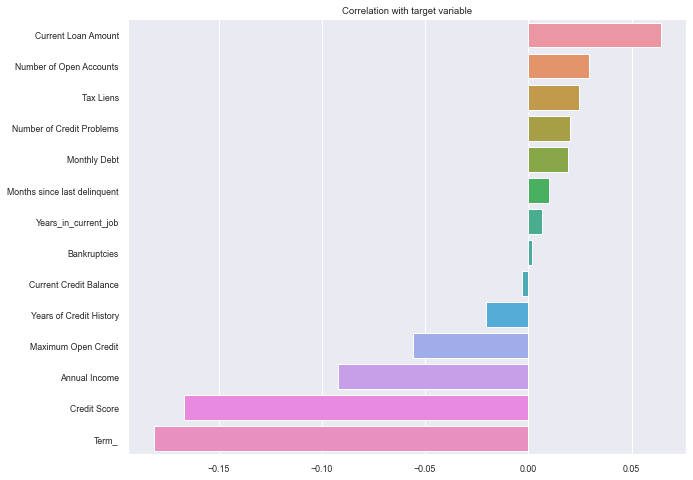

In [76]:
corr_with_target = df_train[NUM_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Сохранение обучающего датасета<a class="anchor" id="saving"></a>

In [78]:
df_train.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')
df_test.to_csv(PREP_TEST_PATH , index=False, encoding='utf-8')

### Загрузка данных

In [79]:
df_train = pd.read_csv(PREP_DATASET_PATH)
df_test = pd.read_csv(PREP_TEST_PATH)

df_train.head()
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Years_in_current_job,Term_,Tax_Liens_Cat,Credit_problem_cat
0,Rent,1178475.0,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0,4,1,tax_middle,cp_middle
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,1,1,tax_middle,cp_middle
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0,3,1,tax_middle,cp_middle
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,10,1,tax_middle,cp_middle
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,6,0,tax_middle,cp_middle


### Подготовка к обучению 

### Выделение целевой переменной и групп признаков

In [80]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()
NUM_FEATURE_NAMES = [
                     'Annual Income', 
#                      'Tax Liens', 
                     'Number of Open Accounts', 
                     'Years of Credit History', 
                     'Maximum Open Credit',
#                      'Number of Credit Problems', 
                     'Months since last delinquent', 
                     'Bankruptcies', 
                     'Current Loan Amount', 
                     'Current Credit Balance', 
                     'Monthly Debt',  
                     'Credit Score', 
                     'Years_in_current_job', 
#                      'Term_'
                    ]

CAT_FEATURE_NAMES = [
                     'Home Ownership', 
#                      'Years in current job', 
                     'Purpose', 
                     'Term', 
                     'Tax_Liens_Cat', 
                     'Credit_problem_cat'
                    ] 


SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES
print(SELECTED_FEATURE_NAMES)

['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Years_in_current_job', 'Home Ownership', 'Purpose', 'Term', 'Tax_Liens_Cat', 'Credit_problem_cat']


### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [81]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]
test = df_test[SELECTED_FEATURE_NAMES]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

In [82]:
y_train.value_counts(), y_test.value_counts()

(0    3771
 1    1479
 Name: Credit Default, dtype: int64,
 0    1616
 1     634
 Name: Credit Default, dtype: int64)

##### Пропустиим балансировку класов, с ней получается хуже

In [80]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [81]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

### Масштабрование данных<a class="anchor" id="scaler"></a>

In [82]:
# scaler = StandardScaler()

# df_train_norm = X.copy()
# X_train_norm = X_train_balanced.copy()
# X_test_norm = X_test.copy()

# X_train_balanced[NUM_FEATURE_NAMES] = scaler.fit_transform(X_train_norm[NUM_FEATURE_NAMES])
# X_test[NUM_FEATURE_NAMES] = scaler.transform(X_test_norm[NUM_FEATURE_NAMES])
# X[NUM_FEATURE_NAMES] = scaler.fit_transform(df_train_norm[NUM_FEATURE_NAMES])

In [88]:
#без балансировки классов

scaler = StandardScaler()

df_train_norm = X.copy()
df_test_norm = df_test.copy()
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

X_train[NUM_FEATURE_NAMES] = scaler.fit_transform(X_train_norm[NUM_FEATURE_NAMES])
X_test[NUM_FEATURE_NAMES] = scaler.transform(X_test_norm[NUM_FEATURE_NAMES])
df_test[NUM_FEATURE_NAMES] = scaler.transform(df_test_norm[NUM_FEATURE_NAMES])
X[NUM_FEATURE_NAMES] = scaler.fit_transform(df_train_norm[NUM_FEATURE_NAMES])

**Сохранение модели для масштабирования данных**

In [84]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Сохранение обучающего и тестового датасетов<a class="anchor" id="train_test_saving"></a>

In [86]:
# train = pd.concat([X_train_balanced, y_train], axis=1)
# test = pd.concat([X_test, y_test], axis=1)

In [89]:
#без балансировки классов
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [90]:
X.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')
df_test.to_csv(PREP_TEST_PATH, index=False, encoding='utf-8')

### Обучим модель catboost

In [91]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, 
                                     cat_features=CAT_FEATURE_NAMES,
#                                      one_hot_max_size=6
                                     )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      3771
           1       0.94      0.46      0.62      1479

    accuracy                           0.84      5250
   macro avg       0.88      0.73      0.76      5250
weighted avg       0.86      0.84      0.82      5250

TEST

              precision    recall  f1-score   support

           0       0.75      0.93      0.83      1616
           1       0.51      0.20      0.28       634

    accuracy                           0.72      2250
   macro avg       0.63      0.56      0.55      2250
weighted avg       0.68      0.72      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1496  120
1                510  124


In [92]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [93]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance]
                                     )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      3771
           1       0.65      0.90      0.75      1479

    accuracy                           0.83      5250
   macro avg       0.80      0.85      0.81      5250
weighted avg       0.87      0.83      0.84      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.68      0.73      1616
           1       0.41      0.57      0.47       634

    accuracy                           0.65      2250
   macro avg       0.60      0.62      0.60      2250
weighted avg       0.69      0.65      0.66      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1093  523
1                274  360


'''
TRAIN

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      3771
           1       0.00      0.00      0.00      1479
Почему метрика f1-score на трейне равна 0 я не понимаю, если делать балансировкву классов, без нее все нормально
'''

**Гиперпараметры catboost**

In [94]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     cat_features=CAT_FEATURE_NAMES,
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall']
                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [95]:
model_catb.best_score_

{'learn': {'Recall:use_weights=false': 0.6984448951994591,
  'Logloss': 0.6273809438047062,
  'F1': 0.6731129553257832,
  'Precision:use_weights=false': 0.4290672451193059,
  'Precision:use_weights=true': 0.6570817254171551,
  'Recall:use_weights=true': 0.6984448951994591},
 'validation': {'Recall:use_weights=false': 0.6640378548895899,
  'Logloss': 0.6439103487148459,
  'F1': 0.6412453214523618,
  'Precision:use_weights=false': 0.405189620758483,
  'Precision:use_weights=true': 0.634619544694866,
  'Recall:use_weights=true': 0.6640378548895899}}

In [96]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.61      0.70      3771
           1       0.40      0.67      0.50      1479

    accuracy                           0.63      5250
   macro avg       0.61      0.64      0.60      5250
weighted avg       0.71      0.63      0.64      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.59      0.69      1616
           1       0.39      0.66      0.49       634

    accuracy                           0.61      2250
   macro avg       0.60      0.63      0.59      2250
weighted avg       0.70      0.61      0.63      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               958  658
1               213  421


### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [97]:
frozen_params = {
     'class_weights':[1, disbalance], 
#      'class_weights':[1, 1],
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}
model_catb = catb.CatBoostClassifier(**frozen_params)

**Подбор гиперпараметров**

In [98]:
params = {'iterations':[50, 200, 500, 700, 1500],
          'max_depth':[3, 5, 7, 8]}

In [99]:
cv = StratifiedKFold(n_splits=5, random_state=21, shuffle=True)

In [100]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5421924816
bestIteration = 49

0:	loss: 0.5421925	best: 0.5421925 (0)	total: 538ms	remaining: 10.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4808805882
bestIteration = 2

1:	loss: 0.4808806	best: 0.5421925 (0)	total: 806ms	remaining: 7.25s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4808805882
bestIteration = 2

2:	loss: 0.4808806	best: 0.5421925 (0)	total: 1.1s	remaining: 6.24s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4808805882
bestIteration = 2

3:	loss: 0.4808806	best: 0.5421925 (0)	total: 1.37s	remaining: 5.48s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4808805882
bestIteration = 2

4:	loss: 0.4808806	best: 0.5421925 (0)	total: 1.67s	remaining: 5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5673408339
bestIteration = 6

5:	loss: 0.5673408	best: 0.5673408 (5)	total: 2.1s	remaining: 4.9s
Stopped by overfitting detector  (20 iterations wait)

be

In [101]:
grid_search

{'params': {'depth': 5, 'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
       

In [102]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head(10)

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
90,90,0.631050,0.040383,0.662605,0.031197,0.643849,0.015402,0.631821,0.025236
63,63,0.630939,0.040022,0.660220,0.028455,0.646233,0.012077,0.636218,0.019233
94,94,0.630900,0.040081,0.662899,0.031562,0.643772,0.015558,0.631557,0.025611
91,91,0.630732,0.039743,0.663018,0.031712,0.643812,0.015476,0.631738,0.025353
87,87,0.630732,0.039743,0.662400,0.030949,0.643962,0.015173,0.632094,0.024855
86,86,0.630732,0.039743,0.662383,0.030928,0.643960,0.015176,0.632154,0.024773
93,93,0.630581,0.039439,0.663065,0.031772,0.643752,0.015597,0.631593,0.025560
83,83,0.630328,0.038934,0.662132,0.030630,0.643985,0.015127,0.632304,0.024569
89,89,0.630328,0.038934,0.662750,0.031375,0.643941,0.015215,0.631942,0.025067
88,88,0.630328,0.038934,0.662873,0.031530,0.643932,0.015233,0.632003,0.024981


### Снижение переобучения 

In [104]:
params = {
    'reg_lambda': np.linspace(0.1, 4, 50)
}

In [105]:
model_catb = catb.CatBoostClassifier(**frozen_params, iterations=200, max_depth=5)

In [106]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6340612451
bestIteration = 74

0:	loss: 0.6340612	best: 0.6340612 (0)	total: 1.89s	remaining: 1m 32s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6232467998
bestIteration = 78

1:	loss: 0.6232468	best: 0.6340612 (0)	total: 3.82s	remaining: 1m 31s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.653121878
bestIteration = 106

2:	loss: 0.6531219	best: 0.6531219 (2)	total: 6.29s	remaining: 1m 38s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6197126418
bestIteration = 81

3:	loss: 0.6197126	best: 0.6531219 (2)	total: 7.95s	remaining: 1m 31s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6340612451
bestIteration = 106

4:	loss: 0.6340612	best: 0.6531219 (2)	total: 9.97s	remaining: 1m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6262041951
bestIteration = 61

5:	loss: 0.6262042	best: 0.6531219 (2)	total: 11.3s	rem

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.624729905
bestIteration = 73

49:	loss: 0.6247299	best: 0.6531219 (2)	total: 1m 43s	remaining: 0us
Estimating final quality...
Training on fold [0/5]

bestTest = 0.6853248518
bestIteration = 57

Training on fold [1/5]

bestTest = 0.635297531
bestIteration = 1

Training on fold [2/5]

bestTest = 0.6876701323
bestIteration = 0

Training on fold [3/5]

bestTest = 0.6185409772
bestIteration = 46

Training on fold [4/5]

bestTest = 0.6794244822
bestIteration = 3



In [107]:
grid_search

{'params': {'l2_leaf_reg': 0.25918367346938775},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
  

In [108]:
%%time

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.65      0.74      3771
           1       0.45      0.74      0.56      1479

    accuracy                           0.68      5250
   macro avg       0.66      0.69      0.65      5250
weighted avg       0.75      0.68      0.69      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.62      0.70      1616
           1       0.40      0.66      0.50       634

    accuracy                           0.63      2250
   macro avg       0.61      0.64      0.60      2250
weighted avg       0.70      0.63      0.65      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               995  621
1               218  416
Wall time: 51.9 ms


**Обучение и оценка лучшей модели**

In [109]:
%%time

final_model = catb.CatBoostClassifier(**frozen_params, iterations=200, max_depth=5, reg_lambda=0.259)
final_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.56      0.67      3771
           1       0.39      0.72      0.51      1479

    accuracy                           0.61      5250
   macro avg       0.61      0.64      0.59      5250
weighted avg       0.71      0.61      0.63      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.57      0.68      1616
           1       0.39      0.71      0.50       634

    accuracy                           0.61      2250
   macro avg       0.61      0.64      0.59      2250
weighted avg       0.71      0.61      0.63      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               921  695
1               187  447
Wall time: 573 ms


### Подбор оптимального размера выборки, кривая обучения

In [110]:
import inspect
print(inspect.getsource(show_learning_curve_plot))

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_st

In [111]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

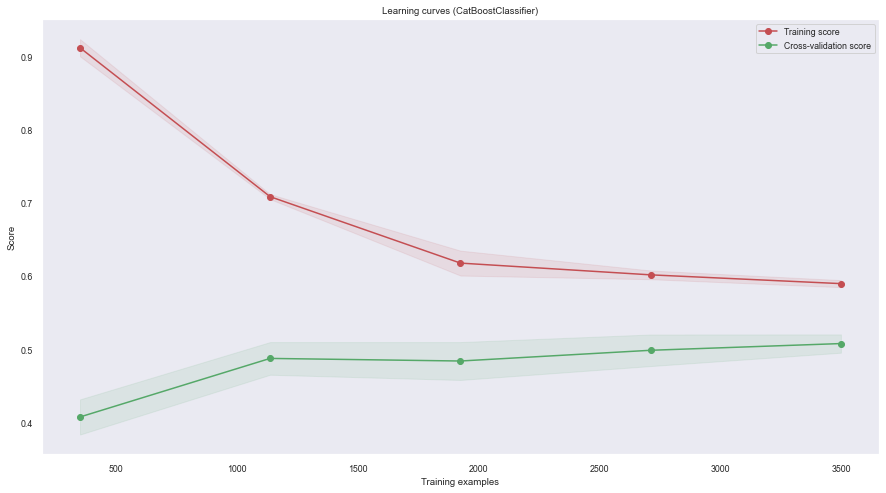

In [112]:
show_learning_curve_plot(final_model, X_train, y_train)

### Выбор порога вероятности для определения класса

In [113]:
y_test_pred_probs = final_model.predict_proba(X_test)
y_test_pred_probs

array([[0.51253011, 0.48746989],
       [0.49846124, 0.50153876],
       [0.50172257, 0.49827743],
       ...,
       [0.53669431, 0.46330569],
       [0.49951678, 0.50048322],
       [0.49951678, 0.50048322]])

In [114]:
print(inspect.getsource(show_proba_calibration_plots))

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, labe

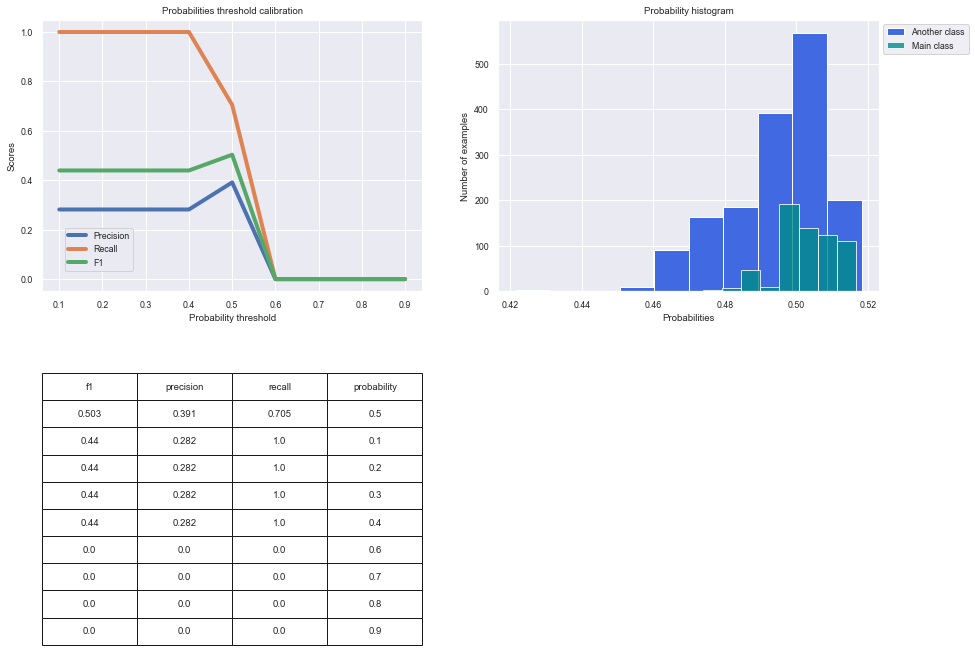

In [115]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков

In [116]:
print(inspect.getsource(show_feature_importances))

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()



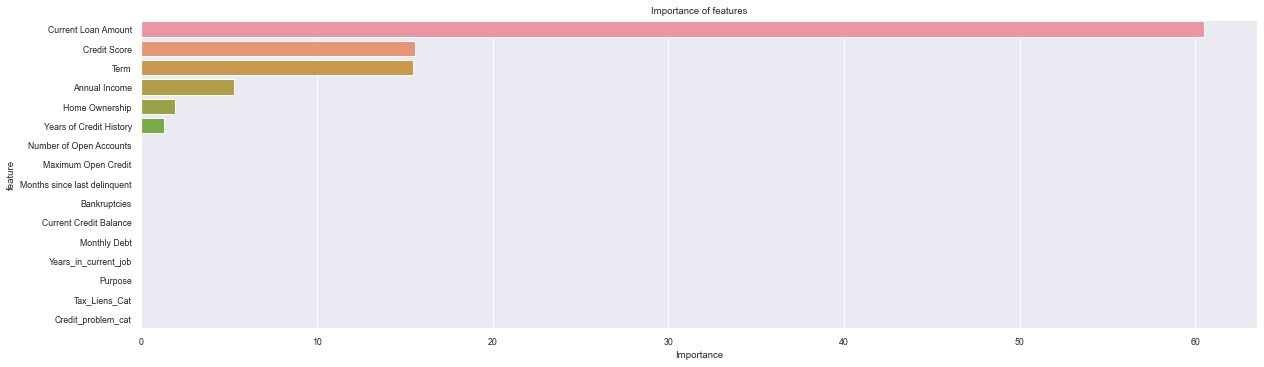

In [118]:
important_features_top = show_feature_importances(X_train.columns,
                                                  final_model.feature_importances_, get_top=6)

In [119]:
important_features_top

['Current Loan Amount',
 'Credit Score',
 'Term',
 'Annual Income',
 'Home Ownership',
 'Years of Credit History']

### Финальная модель

In [120]:
CAT_FEATURE_NAMES

['Home Ownership', 'Purpose', 'Term', 'Tax_Liens_Cat', 'Credit_problem_cat']

In [121]:
NEW_CAT_FEATURE_NAMES = list(set(CAT_FEATURE_NAMES).intersection(set(important_features_top)))
NEW_CAT_FEATURE_NAMES

['Term', 'Home Ownership']

In [122]:
%%time

frozen_params = {
     'class_weights': [1, disbalance], 
     'silent': True,
     'random_state': 21,
     'cat_features': NEW_CAT_FEATURE_NAMES,
     'eval_metric': 'F1',
     'early_stopping_rounds': 20
}

final_model = catb.CatBoostClassifier(**frozen_params,
                                      iterations=200,
                                      max_depth=8,
                                      reg_lambda=2.408)

final_model.fit(X_train[important_features_top], y_train, eval_set=(X_test[important_features_top], y_test))

evaluate_preds(final_model, X_train[important_features_top], X_test[important_features_top], y_train, y_test)


TRAIN

              precision    recall  f1-score   support

           0       0.86      0.51      0.64      3771
           1       0.38      0.78      0.52      1479

    accuracy                           0.59      5250
   macro avg       0.62      0.65      0.58      5250
weighted avg       0.72      0.59      0.60      5250

TEST

              precision    recall  f1-score   support

           0       0.85      0.50      0.63      1616
           1       0.38      0.77      0.51       634

    accuracy                           0.58      2250
   macro avg       0.61      0.64      0.57      2250
weighted avg       0.71      0.58      0.60      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               812  804
1               147  487
Wall time: 585 ms


### Сохранение финальной модели

In [123]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file) 

### Прогнозирование на тестовом датасете

In [124]:
df_test = df_test[important_features_top]


# Прогнозирование на тестовом датасете
y_test_preds_cat = final_model.predict(df_test)

### Сохранение результатов

In [125]:
submit = pd.DataFrame()
submit["Id"] = test_id
submit['Credit Default'] = y_test_preds_cat
submit.to_csv(SUBMIT_PATH, index=False)

In [126]:
pred = pd.read_csv(SUBMIT_PATH)
pred.head(n=20)

,Id,Credit Default
0,0,1
1,1,1
2,2,0
3,3,0
4,4,1
5,5,1
6,6,1
7,7,1
8,8,1
9,9,0
